In [1]:
import torch
import numpy as np
from globalbiopak.linop import *
import matplotlib.pyplot as plt

# Object and forward model definition

In [2]:
# Object definition
in_size = 28
phase_scale = 0.01
phase_img = phase_scale * torch.randn(in_size, in_size)
# in_field = torch.exp(1j * phase_img)

# Imaging system definition (external reference)
ref_strength = 10
op_constant = 1j * LinOpConstant(value=ref_strength)
op_object = LinOpId()
op_extref = op_object + op_constant

# Imaging system definition (internal reference)
fourier_mask = torch.ones(in_size, in_size, dtype=torch.complex64)
fourier_mask[0, 0] = 1j
op_mask = LinOpMul(fourier_mask)
op_fft2 = LinOpFFT2()
op_ifft2 = LinOpIFFT2()
op_pcm = op_ifft2 @ op_mask @ op_fft2

# Forward model function
def forward_model(phase, op):
    return torch.abs(op.apply(torch.exp(1j * phase)))**2
meas_intensity_pcm = forward_model(phase_img, op_pcm)
meas_intensity_ext = forward_model(phase_img, op_extref)

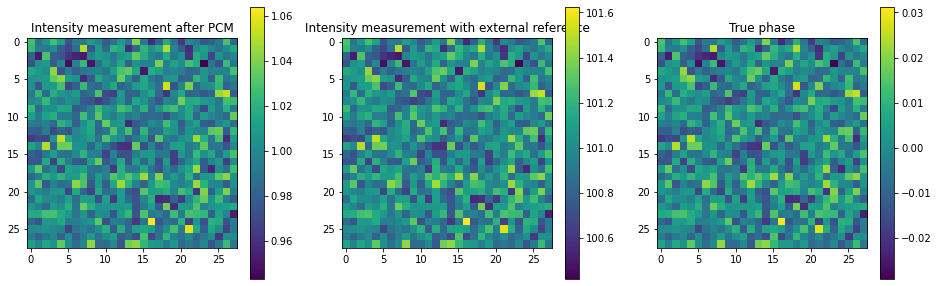

In [3]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(meas_intensity_pcm)
plt.colorbar()
plt.title('Intensity measurement after PCM');
plt.subplot(132)
plt.imshow(meas_intensity_ext)
plt.colorbar()
plt.title('Intensity measurement with external reference');
plt.subplot(133)
plt.imshow(phase_img)
plt.colorbar()
plt.title('True phase');

# FI matrix and CRB computation

In [4]:
# Jacobian computation
torch._C._debug_only_display_vmap_fallback_warnings(True)
raw_jacobian_pcm = torch.autograd.functional.jacobian(lambda x: forward_model(x, op_pcm), phase_img, create_graph=True, vectorize=True)
jacobian_pcm = torch.reshape(raw_jacobian_pcm, [in_size**2, in_size**2])

# Forward model and Fisher Information matrix
output_img_pcm = forward_model(phase_img, op_pcm).reshape(in_size**2)
FIm_pcm = (jacobian_pcm.T / (output_img_pcm+1e-5)) @ jacobian_pcm  # important to do it with this order of operations

# Diagonal Cramér-Rao bound
diagcrb_pcm = 1 / torch.diag(FIm_pcm).reshape([28, 28])

# Tighter Cramér-Rao bound on whole matrix
invFIm_pcm = torch.linalg.inv(FIm_pcm)
crb_pcm = torch.diag(invFIm_pcm).reshape([28, 28])

/home/jdong/.conda/envs/tomosipo2/lib/python3.8/site-packages/torch/autograd/__init__.py:226: UserWarning: Batching rule not implemented for aten::_fft_c2c falling back to slow (for loop and stack) implementation (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/aten/src/ATen/BatchedFallback.cpp:74.)
  return Variable._execution_engine.run_backward(


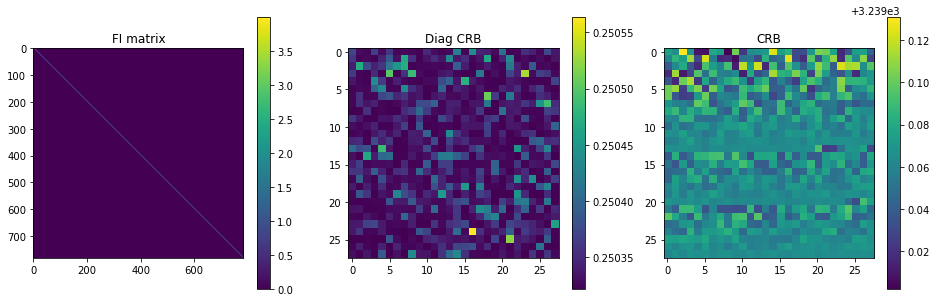

In [5]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(FIm_pcm.detach())
plt.colorbar()
plt.title('FI matrix');
plt.subplot(132)
plt.imshow(diagcrb_pcm.detach())
plt.colorbar()
plt.title('Diag CRB');
plt.subplot(133)
plt.imshow(crb_pcm.detach())
plt.colorbar()
plt.title('CRB');

In [6]:
# Jacobian computation
torch._C._debug_only_display_vmap_fallback_warnings(True)
raw_jacobian_extref = torch.autograd.functional.jacobian(lambda x: forward_model(x, op_extref), phase_img, create_graph=True, vectorize=True)
jacobian_extref = torch.reshape(raw_jacobian_extref, [in_size**2, in_size**2])

# Forward model and Fisher Information matrix
output_img_extref = forward_model(phase_img, op_extref).reshape(in_size**2)
FIm_extref = (jacobian_extref.T / (output_img_extref+1e-5)) @ jacobian_extref  # important to do it with this order of operations

# Diagonal Cramér-Rao bound
diagcrb_extref = 1 / torch.diag(FIm_extref).reshape([28, 28])

# Tighter Cramér-Rao bound on whole matrix
invFIm_extref = torch.linalg.inv(FIm_extref)
crb_extref = torch.diag(invFIm_extref).reshape([28, 28])

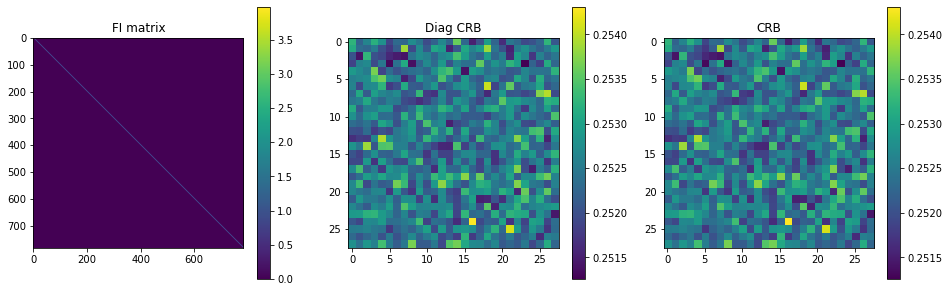

In [7]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(FIm_extref.detach())
plt.colorbar()
plt.title('FI matrix');
plt.subplot(132)
plt.imshow(diagcrb_extref.detach())
plt.colorbar()
plt.title('Diag CRB');
plt.subplot(133)
plt.imshow(crb_extref.detach())
plt.colorbar()
plt.title('CRB');